In [6]:
import os
import tensorflow as tf 
from tensorflow.python.client import device_lib

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'


gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)

if gpus:
    try:
        # GPU 메모리 사용량을 제한할 크기(MB 단위)
        memory_limit = 46068 / 4  # 예: 4GB로 제한
        
        # GPU마다 메모리 제한 설정
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
        print(f"GPU 메모리 사용량이 {memory_limit}MB로 제한되었습니다.")
    except RuntimeError as e:
        print(e)

import os
os.environ['CUDA_HOME'] = '/home/j-k11s207/.conda/envs/bong2'
os.environ['LD_LIBRARY_PATH'] = '/home/j-k11s207/.conda/envs/bong2/lib'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU 메모리 사용량이 11517.0MB로 제한되었습니다.


In [7]:
!pwd

/home/j-k11s207/cha


In [8]:
import sys
sys.path.append('/home/j-k11s207/.local/lib/python3.10/site-packages')

In [9]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 경로 설정
# 데이터 경로 설정
positive_audio_folder = './raw_data/heySsafy'  # 긍정 데이터 폴더 경로
negative_audio_folder = './raw_data/heySsafyNegative'  # 부정 데이터 폴더 경로
output_folder_positive = 'home/j-k11s207/lsb/raw_data/positive/spectrograms'  # 긍정 데이터 스펙트로그램 저장 경로
output_folder_negative = 'home/j-k11s207/lsb/raw_data/negative/spectrograms'  # 부정 데이터 스펙트로그램 저장 경로
os.makedirs(output_folder_positive, exist_ok=True)
os.makedirs(output_folder_negative, exist_ok=True)

# 샘플링 레이트 설정
sr = 32000  # 팀원이 준비한 샘플링 레이트로 설정

# 오디오 파일을 스펙트로그램으로 변환하는 함수
def preprocess_audio(file_path, sr=32000, n_mels=128, hop_length=512):
    y, _ = librosa.load(file_path, sr=sr)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram.T  # 시간축을 앞으로 변환

# 스펙트로그램을 시각화하고 저장하는 함수
def save_spectrogram(spectrogram, save_path):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# 오디오 파일 리스트 가져오기
positive_audio_files = glob.glob(os.path.join(positive_audio_folder, '*.wav'))
negative_audio_files = glob.glob(os.path.join(negative_audio_folder, '*.wav'))

# 리스트가 비어 있는지 확인
print(f"Number of positive audio files: {len(positive_audio_files)}")
print(f"Number of negative audio files: {len(negative_audio_files)}")

Number of positive audio files: 1204
Number of negative audio files: 1200


In [11]:
# 긍정 데이터에 대해 스펙트로그램 생성 및 저장
X = []
y = []
xidx = 0
for audio_file in positive_audio_files:
    xidx += 1
    file_path = audio_file
    spectrogram = preprocess_audio(file_path, sr=sr)
    X.append(spectrogram)
    y.append(1)  # 긍정 레이블
    save_path = os.path.join(output_folder_positive, os.path.basename(audio_file).replace('.wav', '.png'))
    save_spectrogram(spectrogram, save_path)
    if (xidx % 100 == 0): print(f'xidx: {xidx}')
    # print(f"Processed and saved positive data: {save_path}")

# 부정 데이터에 대해 스펙트로그램 생성 및 저장
yidx = 0
for audio_file in negative_audio_files:
    yidx += 1
    file_path = audio_file
    spectrogram = preprocess_audio(file_path, sr=sr)
    X.append(spectrogram)
    y.append(0)  # 부정 레이블
    save_path = os.path.join(output_folder_negative, os.path.basename(audio_file).replace('.wav', '.png'))
    save_spectrogram(spectrogram, save_path)
    if (yidx % 100 == 0): print(f'yidx: {yidx}')
    # print(f"Processed and saved negative data: {save_path}")

print("데이터 준비 완료!")

# 데이터 배열 변환 및 학습/검증 분할
X = np.array(X)
y = np.array(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

xidx: 100
xidx: 200
xidx: 300
xidx: 400
xidx: 500
xidx: 600
xidx: 700
xidx: 800
xidx: 900
xidx: 1000
xidx: 1100
xidx: 1200
yidx: 100
yidx: 200
yidx: 300
yidx: 400
yidx: 500
yidx: 600
yidx: 700
yidx: 800
yidx: 900
yidx: 1000
yidx: 1100
yidx: 1200
데이터 준비 완료!


Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 126, 128)]        0         
                                                                 
 conv1d_22 (Conv1D)          (None, 126, 32)           12320     
                                                                 
 batch_normalization_66 (Bat  (None, 126, 32)          128       
 chNormalization)                                                
                                                                 
 dropout_66 (Dropout)        (None, 126, 32)           0         
                                                                 
 gru_44 (GRU)                (None, 126, 64)           18816     
                                                                 
 batch_normalization_67 (Bat  (None, 126, 64)          256       
 chNormalization)                                         

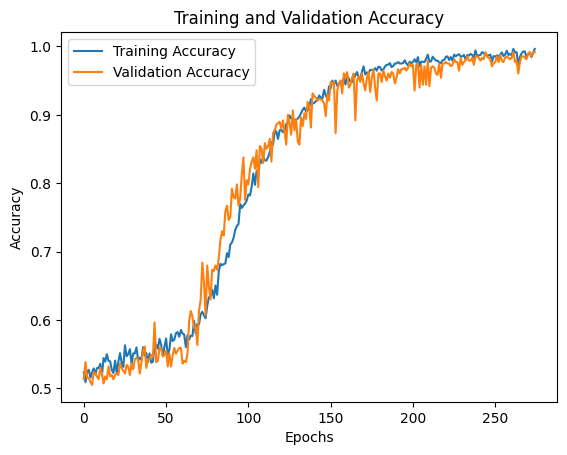

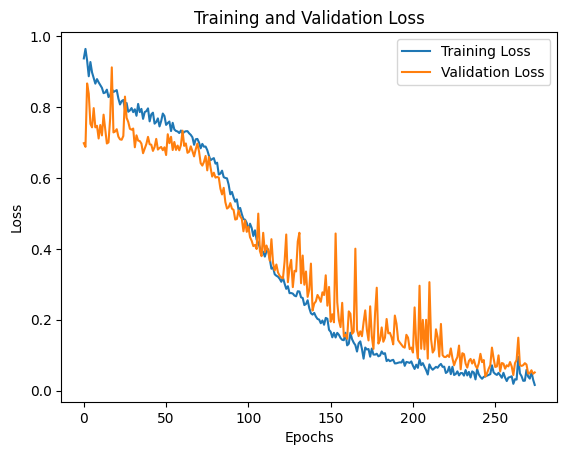

모델 학습 완료!
모델이 저장되었습니다.
16/16 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       234
           1       1.00      0.99      0.99       247

    accuracy                           0.99       481
   macro avg       0.99      0.99      0.99       481
weighted avg       0.99      0.99      0.99       481

모델 평가 완료!


In [34]:
from tensorflow.keras.optimizers import Adam

# 향상된 GRU 모델 정의
def build_gru_model(input_shape):
    X_input = Input(shape=input_shape)
    X = Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu')(X_input)
    X = BatchNormalization()(X)
    X = Dropout(0.3)(X)  # Dropout 비율 조정
    X = GRU(64, return_sequences=True)(X)
    X = BatchNormalization()(X)
    X = Dropout(0.4)(X)
    X = GRU(64)(X)
    X = BatchNormalization()(X)
    X = Dropout(0.4)(X)
    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs=X_input, outputs=X)
    model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 모델 학습
input_shape = (X_train.shape[1], X_train.shape[2])  # 입력 형상 설정
model = build_gru_model(input_shape)
model.summary()

# EarlyStopping 콜백 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# 학습 및 검증 손실 시각화
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

print("모델 학습 완료!")

# 모델 저장
model.save("trigger_word_detection_model_B32_lr1e-4_pat20.h5")
print("모델이 저장되었습니다.")

# 테스트 데이터에 대한 예측 및 평가
predictions = model.predict(X_val)
threshold = 0.5  # 임계값 설정
predicted_labels = (predictions > threshold).astype(int).flatten()

# 성능 평가
from sklearn.metrics import classification_report
print(classification_report(y_val, predicted_labels))

print("모델 평가 완료!")